In [1]:
import torch
import torch.nn.functional as F
import json
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [2]:
from tqdm import tqdm

In [3]:
from sklearn.metrics import confusion_matrix
import scipy as sp
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
import copy
from sklearn.cluster import SpectralClustering

In [4]:
project_dir = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [5]:
result_path = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2'
detected_origin_path = f'{result_path}/checkpoints/motifs-predcls-base-feature-exmp/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

KeyboardInterrupt: 

In [5]:
idx2pred = vocab_file["idx_to_predicate"]
pred_cnt = vocab_file["predicate_count"]

In [9]:
def balanced_tree_building(labels, cls):
    cnts = []
    clusters = []
    for i in range(1, len(set(cls))+1):
        cnt = 0
        for l in labels[cls==i]:
            cnt += pred_cnt[l]
        cnts.append(cnt)
        clusters.append(labels[cls==i].tolist())
    clusters = np.array(clusters, dtype=object)
    log_cnts = np.log10(cnts).astype(int)
    new_clusters = []
    for num in range(np.max(log_cnts)+1):
        tmp = []
        mask = log_cnts==num
        if any(mask):
            print(num)
            new_clusters.append(clusters[mask])
    new_clusters.reverse()
    return new_clusters


# confusion matrix

In [10]:
def bbox_match(pred, gt):
    """Args:
        pred: [x0, y0, x1, y1]
        gt: same as above
    Returns: whether objects in gt and prediction are seen as same objects
    """
    xA = max(pred[0], gt[0])
    yA = max(pred[1], gt[1])
    xB = min(pred[2], gt[2])
    yB = min(pred[3], gt[3])
    intra_area = max(0, xB-xA+1)*max(0, yB-yA+1)
    pred_area = (pred[2]-pred[0]+1)*(pred[3]-pred[1]+1)
    gt_area = (gt[2]-gt[0]+1)*(gt[3]-gt[1]+1)
    iou = intra_area/float(pred_area+gt_area-intra_area)
    return iou>0.5

In [11]:
def find_match(pred_rels, gt_rels):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int)
    """
    selected_pred_label = []
    selected_gt_label = []
    for pre in pred_rels:
        for gt in gt_rels:
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                selected_pred_label.append(pre["rel_label"])
                selected_gt_label.append(gt["rel_label"])
    return selected_pred_label, selected_gt_label

In [12]:
pred = []
gt = []
for i in tqdm(range(26446)):
    prediction = detected_origin_result["predictions"][i]
    groundtruths = detected_origin_result["groundtruths"][i]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").tolist()
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = tri[2]
        gt_rels.append(tmp)
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:100]
    for j, k in zip(pred_rel_pair, pred_rel_label.tolist()):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = k
        pred_rels.append(tmp)
    selected_pred_label, selected_gt_label = find_match(pred_rels, gt_rels)
    pred = pred+selected_pred_label
    gt = gt+selected_gt_label
    

100%|██████████| 26446/26446 [00:26<00:00, 992.34it/s]


In [13]:
len(pred) == len(gt)

True

In [14]:
pred_cnt = vocab_file["predicate_count"]

In [15]:
# confusion matrix
val_mat = confusion_matrix(gt, pred)

In [16]:
val_mat.shape

(50, 50)

In [17]:
mat = copy.deepcopy(val_mat).astype(float)
for i in range(mat.shape[0]):
    mat[i] = mat[i]/np.sum(mat[i])

In [18]:
labels = np.array([idx2pred[str(l)] for l in set(gt)],dtype=str)

<AxesSubplot:>

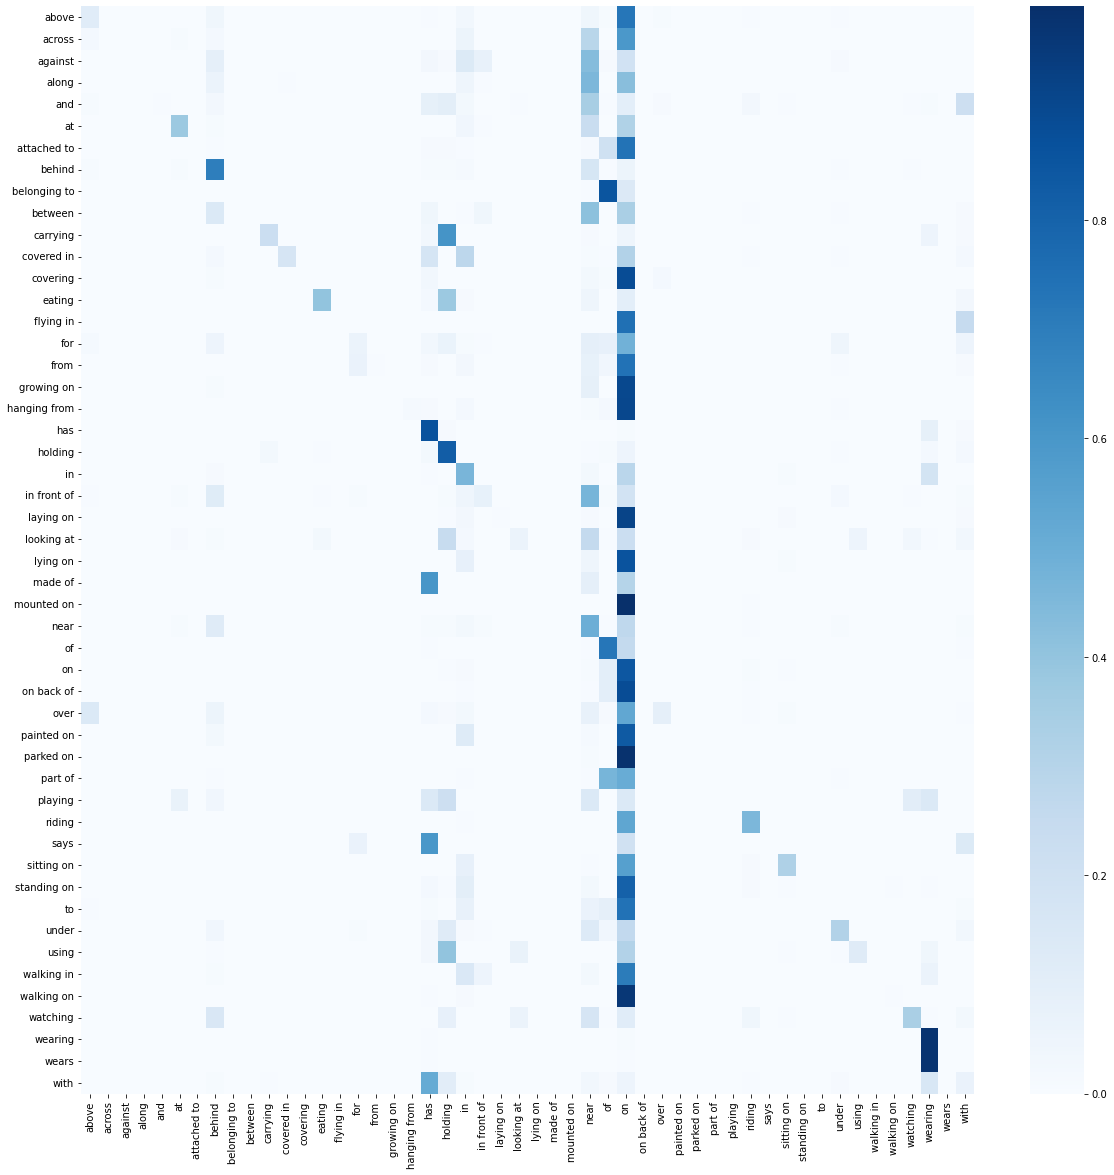

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(mat, cmap="Blues", xticklabels=labels, yticklabels=labels)

## Hierarchical Clustering

In [20]:
z = hierarchy.linkage(data, method="ward", metric="euclidean")

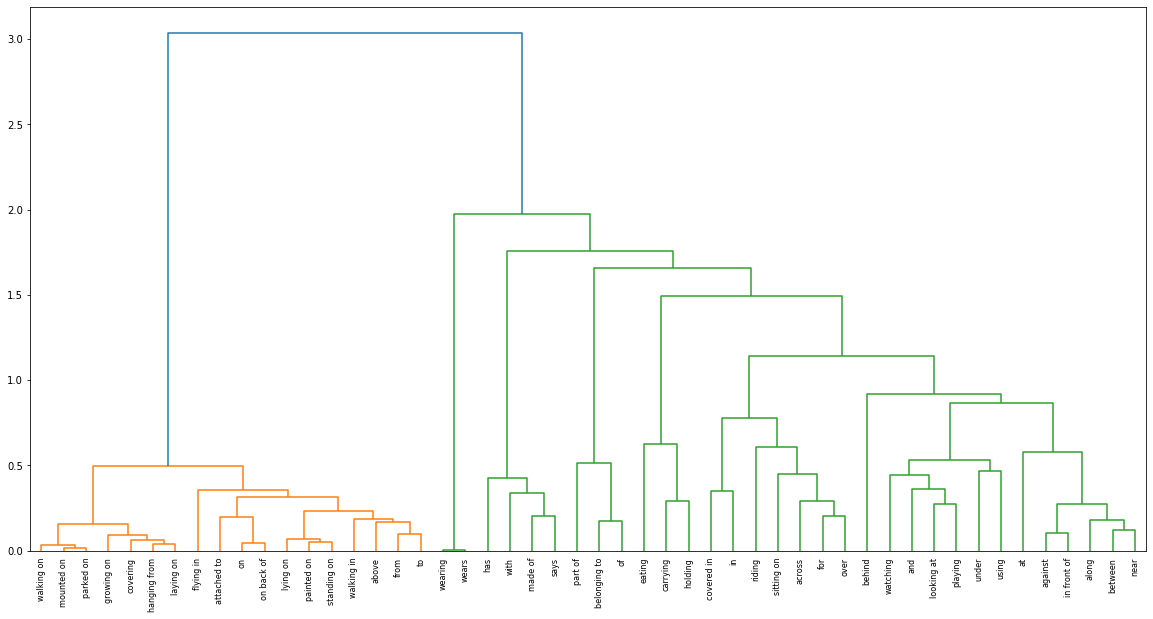

In [28]:
plt.figure(figsize=(20,10))
ax = hierarchy.dendrogram(z, show_contracted=True, labels=labels)
# plt.savefig("./motif-predcls-conf-cls.png", dpi=300, bbox_inches="tight")

In [26]:
cls = hierarchy.fcluster(z, t=0.4, criterion="distance")
len(set(cls))

20

In [380]:
balanced_tree_building(labels, cls)

[array([list(['above', 'attached to', 'covering', 'from', 'on', 'on back of', 'painted on', 'standing on', 'to']),
        list(['belonging to', 'of']), list(['in']),
        list(['between', 'in front of', 'near']),
        list(['wearing', 'wears']), list(['has', 'made of', 'says'])],
       dtype=object),
 array([list(['growing on', 'hanging from', 'laying on', 'lying on', 'mounted on', 'parked on', 'walking on']),
        list(['across', 'over']), list(['sitting on']),
        list(['carrying', 'holding']), list(['under']), list(['behind']),
        list(['with'])], dtype=object),
 array([list(['for']), list(['walking in']), list(['riding']),
        list(['eating']), list(['playing']), list(['part of']),
        list(['covered in']), list(['looking at', 'watching']),
        list(['and']), list(['using']), list(['along']), list(['against']),
        list(['at'])], dtype=object)]

In [27]:
for i in range(1,len(set(cls))+1):
    print(labels[cls==i])
    cnt = 0
    for l in labels[cls==i]:
        cnt += pred_cnt[l]
    print(cnt)

['covering' 'growing on' 'hanging from' 'laying on' 'mounted on'
 'parked on' 'walking on']
28879
['above' 'attached to' 'flying in' 'from' 'lying on' 'on' 'on back of'
 'painted on' 'standing on' 'to' 'walking in']
800178
['wearing' 'wears']
151556
['made of' 'says' 'with']
71046
['has']
277936
['belonging to' 'of']
149627
['part of']
2065
['carrying' 'holding']
47935
['eating']
4688
['covered in' 'in']
254068
['across' 'for' 'over']
20458
['sitting on']
18643
['riding']
8856
['and' 'looking at' 'playing']
10370
['watching']
3490
['under']
22596
['using']
1925
['against' 'along' 'between' 'in front of' 'near']
120431
['at']
9903
['behind']
41356


## Kmeans

In [282]:
def elbow(x, max_k):
    inertia = np.zeros((max_k,))
    for i in range(1,max_k+1):
        kmeans = KMeans(n_clusters=i)
        cls = kmeans.fit_predict(x)
        inertia[i-1] = kmeans.inertia_
    return inertia


In [283]:
inertia = elbow(mat, 40)

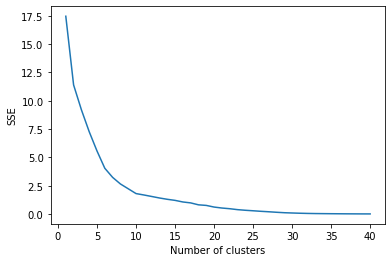

In [284]:
plt.plot([i+1 for i in range(40)],inertia)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [47]:
n_clusters = 25
cls = KMeans(n_clusters=n_clusters, random_state=5).fit_predict(mat)
for i in range(n_clusters):
    print(labels[cls==i])

['eating']
['growing on' 'hanging from' 'laying on' 'lying on' 'mounted on'
 'parked on' 'walking on']
['against']
['with']
['belonging to' 'of']
['wearing' 'wears']
['looking at' 'watching']
['covered in']
['behind']
['for']
['carrying' 'holding']
['has' 'made of' 'says']
['walking in']
['along' 'between' 'in front of' 'near']
['playing']
['across' 'over']
['part of']
['at']
['riding']
['and']
['using']
['in']
['under']
['above' 'attached to' 'covering' 'from' 'on' 'on back of' 'painted on'
 'standing on' 'to']
['sitting on']


# Visual tree

In [12]:
labels = np.array([idx2pred[str(l)] for l in range(1,51)], dtype=str)

## data from npy file

In [7]:
vis_info_path = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/checkpoints/motifs-sgdet-exmp/concat/vis_record/vis.npy"
# vis_info_path2 = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/checkpoints/motifs-predcls-exmp/vis_record>20653/vis.npy"

In [8]:
vis_info = np.load(vis_info_path, allow_pickle=True).item()
# vis_info2 = np.load(vis_info_path2, allow_pickle=True).item()

In [9]:
vis_info.keys()

dict_keys(['avg_feature'])

In [ ]:
data = vis_info["avg_feature"][1:]
data

In [19]:
combined_vis_info = copy.deepcopy(vis_info)
combined_vis_info["feat_sum"] = (combined_vis_info["feat_sum"]+vis_info2["feat_sum"])[1:]
combined_vis_info["feat_sq"] = (combined_vis_info["feat_sq"]+vis_info2["feat_sq"])[1:]
combined_vis_info["freq_sum"] = (combined_vis_info["freq_sum"]+vis_info2["freq_sum"])[1:]
combined_vis_info["freq_sq"] = (combined_vis_info["freq_sq"]+vis_info2["freq_sq"])[1:]
combined_vis_info["cnt"] = (combined_vis_info["cnt"]+vis_info2["cnt"])[1:]

KeyError: 'feat_sum'

In [61]:
combined_vis_info["feat_ave"] = copy.deepcopy(combined_vis_info["feat_sum"])
combined_vis_info["freq_ave"] = copy.deepcopy(combined_vis_info["freq_sum"])
for i in range(50):
    combined_vis_info["feat_ave"][i] /= combined_vis_info["cnt"][i]
    combined_vis_info["freq_ave"][i] /= combined_vis_info["cnt"][i]

## data from checkpoint

In [6]:
ckpt_file = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/checkpoints/motifs-predcls-exmp/record/model_0000100.pth"

In [7]:
t = torch.load(ckpt_file, map_location=torch.device("cpu"))

In [9]:
data = t["model"]["roi_heads.relation.predictor.class_features"][1:]
data

tensor([[ 0.1727,  0.0305,  0.2818,  ..., -6.9077, -6.9078, -6.6980],
        [ 0.0487,  0.1370,  0.2795,  ..., -6.8906, -6.8896, -6.7782],
        [ 0.6479,  0.7355,  0.4242,  ..., -6.2692, -6.2742, -6.2457],
        ...,
        [ 0.6562,  0.6242,  0.0942,  ..., -1.7582, -4.2185, -5.2074],
        [ 0.2751,  0.5592,  0.1390,  ..., -1.5424, -3.7620, -4.9229],
        [ 0.1903,  0.0312,  0.7480,  ..., -5.7413, -6.2081, -3.9420]])

## Spectral clustering

In [141]:
dif_mat = np.zeros((50,50))

In [159]:
np.all(combined_vis_info["freq_sum"]>0)

True

In [168]:
for i in range(50):
    for j in range(50):
        feat_dis = 0
        feat_dis += (combined_vis_info["feat_sq"][i] - 2*(combined_vis_info["feat_sum"][i]*combined_vis_info["feat_ave"][i])).sum()/combined_vis_info["cnt"][i]
        feat_dis += (combined_vis_info["feat_ave"][i]**2).sum()
        feat_dis += (combined_vis_info["feat_sq"][j] - 2*(combined_vis_info["feat_sum"][j]*combined_vis_info["feat_ave"][j])).sum()/combined_vis_info["cnt"][j]
        feat_dis += (combined_vis_info["feat_ave"][j]**2).sum()
        feat_dis += ((combined_vis_info["feat_ave"][i] - combined_vis_info["feat_ave"][j])**2).sum()
        feat_dis = np.sqrt(feat_dis)
        freq_dis = 0
        freq_dis += (combined_vis_info["freq_sq"][i] - 2*(combined_vis_info["freq_sum"][i]*combined_vis_info["freq_ave"][i])).sum()/combined_vis_info["cnt"][i]
        freq_dis += (combined_vis_info["freq_ave"][i]**2).sum()
        freq_dis += (combined_vis_info["freq_sq"][j] - 2*(combined_vis_info["freq_sum"][j]*combined_vis_info["freq_ave"][j])).sum()/combined_vis_info["cnt"][j]
        freq_dis += (combined_vis_info["freq_ave"][j]**2).sum()
        freq_dis += ((combined_vis_info["freq_ave"][i] - combined_vis_info["freq_ave"][j])**2).sum()
        freq_dis = np.sqrt(freq_dis)
        # print(feat_dis, freq_dis)
        dif_mat[i][j] = feat_dis + freq_dis

In [169]:
dif_mat

array([[0.28072301, 0.26898589, 0.27322482, ..., 0.30950938, 0.30991175,
        0.30137465],
       [0.26898589, 0.19616778, 0.17923372, ..., 0.2726736 , 0.27376393,
        0.23812985],
       [0.27322482, 0.17923372, 0.14650913, ..., 0.2645561 , 0.2658945 ,
        0.2195728 ],
       ...,
       [0.30950938, 0.2726736 , 0.2645561 , ..., 0.11676353, 0.11826953,
        0.25605689],
       [0.30991175, 0.27376393, 0.2658945 , ..., 0.11826953, 0.11969886,
        0.25693036],
       [0.30137465, 0.23812985, 0.2195728 , ..., 0.25605689, 0.25693036,
        0.22759448]])

### dif_mat

In [231]:
num_cluster = 20
spkm = SpectralClustering(n_clusters=num_cluster, affinity="precomputed")
res = spkm.fit(dif_mat)
res.labels_

array([ 0,  0, 10,  6, 11,  0,  0, 13, 19,  4,  0,  2,  0,  0, 14,  0,  8,
        3,  0,  0,  0,  0,  9,  0,  0,  0,  1,  5,  0, 15,  0,  0,  0,  0,
       16, 17,  0,  0, 12,  0,  0,  0,  0,  0,  7, 18,  0,  0,  0,  0],
      dtype=int32)

In [232]:
for i in range(num_cluster):
    print(labels[res.labels_==i])

['above' 'across' 'at' 'attached to' 'carrying' 'covering' 'eating' 'for'
 'hanging from' 'has' 'holding' 'in' 'laying on' 'looking at' 'lying on'
 'near' 'on' 'on back of' 'over' 'painted on' 'playing' 'riding'
 'sitting on' 'standing on' 'to' 'under' 'using' 'watching' 'wearing'
 'wears' 'with']
['made of']
['covered in']
['growing on']
['between']
['mounted on']
['along']
['walking in']
['from']
['in front of']
['against']
['and']
['says']
['behind']
['flying in']
['of']
['parked on']
['part of']
['walking on']
['belonging to']


### average_feature

In [225]:
combined_vis_info["fused_ave"] = np.concatenate([combined_vis_info["feat_ave"], combined_vis_info["freq_ave"]], axis=1)

In [227]:
num_cluster = 30
spkm = SpectralClustering(n_clusters=num_cluster, affinity="nearest_neighbors")
res = spkm.fit(combined_vis_info["fused_ave"])
res.labels_

array([ 4, 12,  1,  1, 29,  6, 14,  8, 11,  8,  3, 10,  1, 13, 18,  2, 17,
       14,  6,  9, 23, 16, 26,  0,  6,  0,  5, 25, 12, 11, 21, 19,  2,  3,
        0, 11, 22, 15, 24, 27,  4,  3,  2, 23, 17, 28,  2,  7,  7, 20],
      dtype=int32)

In [228]:
for i in range(num_cluster):
    print(labels[res.labels_==i])

['laying on' 'lying on' 'parked on']
['against' 'along' 'covering']
['for' 'over' 'under' 'watching']
['carrying' 'painted on' 'to']
['above' 'standing on']
['made of']
['at' 'hanging from' 'looking at']
['wearing' 'wears']
['behind' 'between']
['has']
['covered in']
['belonging to' 'of' 'part of']
['across' 'near']
['eating']
['attached to' 'growing on']
['riding']
['in']
['from' 'walking in']
['flying in']
['on back of']
['with']
['on']
['playing']
['holding' 'using']
['says']
['mounted on']
['in front of']
['sitting on']
['walking on']
['and']


## kmeans

In [63]:
combined_vis_info["fused_ave"] = np.concatenate([combined_vis_info["feat_ave"], combined_vis_info["freq_ave"]], axis=1)

In [64]:
def elbow(x, max_k):
    inertia = np.zeros((max_k,))
    for i in range(1,max_k+1):
        kmeans = KMeans(n_clusters=i, random_state=10)
        cls = kmeans.fit_predict(x)
        inertia[i-1] = kmeans.inertia_
    return inertia


In [65]:
inertia = elbow(combined_vis_info["fused_ave"], 40)

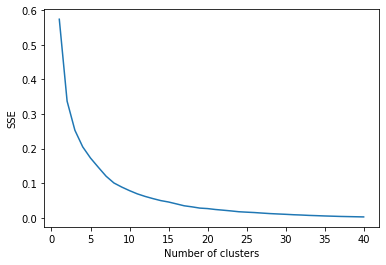

In [66]:
plt.plot([i+1 for i in range(40)],inertia)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [68]:
n_clusters = 15
cls = KMeans(n_clusters=n_clusters, random_state=10).fit_predict(combined_vis_info["fused_ave"])
for i in range(n_clusters):
    print(labels[cls==i])
    cnt = 0
    for l in labels[cls==i]:
        cnt += pred_cnt[l]
    print(cnt)

['against' 'and' 'behind' 'between' 'covered in' 'flying in' 'in front of'
 'made of' 'playing' 'says' 'watching']
81257
['above' 'attached to' 'hanging from' 'to']
69942
['wearing' 'wears']
151556
['carrying' 'holding' 'looking at']
51018
['across' 'along' 'at' 'covering' 'for' 'from' 'growing on' 'near' 'over'
 'under' 'walking in']
163514
['laying on' 'lying on' 'parked on']
8329
['belonging to' 'of' 'part of']
151692
['with']
66425
['riding']
8856
['in']
251756
['eating']
4688
['mounted on' 'on' 'on back of' 'painted on']
719671
['has']
277936
['sitting on' 'standing on' 'walking on']
37441
['using']
1925


In [34]:
balanced_tree_building(labels, cls+1)

3
4
5


[array([list(['wearing', 'wears']),
        list(['mounted on', 'on', 'on back of', 'painted on']),
        list(['belonging to', 'of', 'part of']), list(['has']),
        list(['in']),
        list(['across', 'along', 'for', 'from', 'near', 'over'])],
       dtype=object),
 array([list(['at', 'covering', 'growing on', 'walking in']),
        list(['against', 'between', 'covered in', 'in front of', 'under', 'watching']),
        list(['carrying', 'holding', 'looking at']), list(['with']),
        list(['above', 'attached to', 'hanging from', 'to']),
        list(['standing on', 'walking on']), list(['sitting on']),
        list(['and', 'behind', 'made of', 'playing', 'says'])],
       dtype=object),
 array([list(['riding']), list(['eating']),
        list(['laying on', 'lying on']), list(['flying in']),
        list(['using']), list(['parked on'])], dtype=object)]

## Hierarchical Clustering

In [10]:
z = hierarchy.linkage(data, method="ward", metric="euclidean")
# z = hierarchy.linkage(combined_vis_info["freq_ave"], method="ward", metric="euclidean")

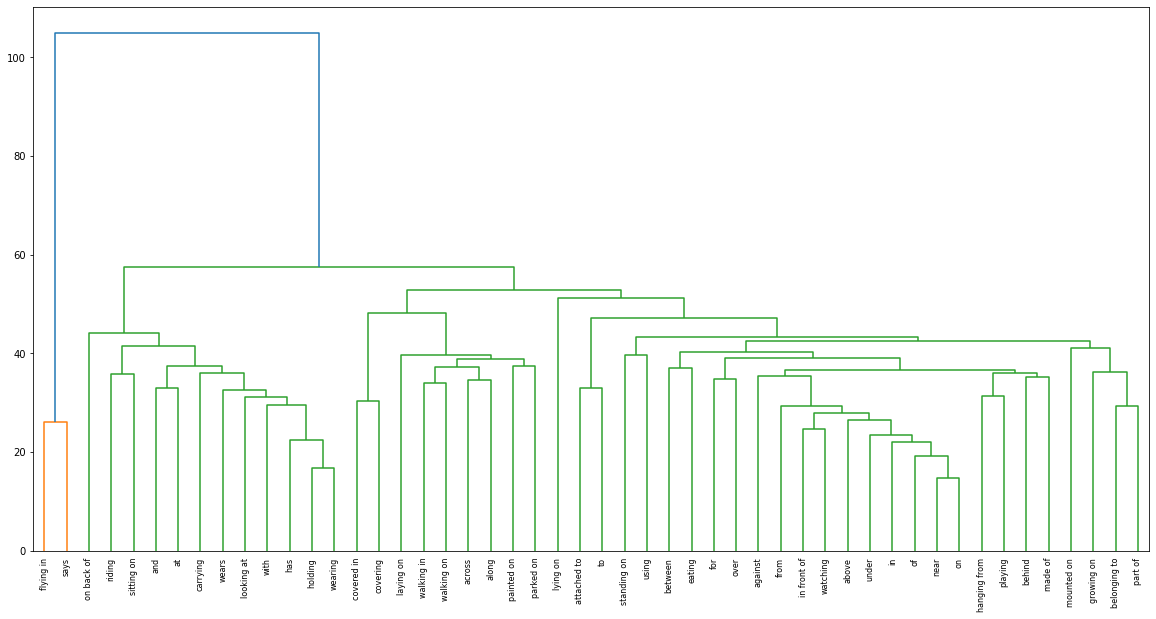

In [13]:
plt.figure(figsize=(20,10))
ax = hierarchy.dendrogram(z, show_contracted=True, labels=labels)
# plt.savefig("./feat-basic-cls.png", dpi=300, bbox_inches="tight")

In [15]:
cls = hierarchy.fcluster(z, t=2, criterion="maxclust")
len(set(cls))

2

In [16]:
labels = np.array(labels, dtype=str)
for i in range(1,len(set(cls))+1):
    print(labels[cls==i])
    cnt = 0
    for l in labels[cls==i]:
        cnt += pred_cnt[l]
    print(cnt)

['flying in' 'says']
4214
['above' 'across' 'against' 'along' 'and' 'at' 'attached to' 'behind'
 'belonging to' 'between' 'carrying' 'covered in' 'covering' 'eating'
 'for' 'from' 'growing on' 'hanging from' 'has' 'holding' 'in'
 'in front of' 'laying on' 'looking at' 'lying on' 'made of' 'mounted on'
 'near' 'of' 'on' 'on back of' 'over' 'painted on' 'parked on' 'part of'
 'playing' 'riding' 'sitting on' 'standing on' 'to' 'under' 'using'
 'walking in' 'walking on' 'watching' 'wearing' 'wears' 'with']
2041792
